## 1. DataSet import

In [17]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from prepare_datasets import *
from Helper_functions import *

X, y, feature_names, categorical_features, continuous_features, actionable_features= get_and_preprocess_cc()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_pos = X[y == 1]
X_neg = X[y == 0]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

## 2. Model

In [18]:
from Model import NeuralNetwork

In [19]:
torch.manual_seed(42)
model = NeuralNetwork(X.shape[1], 200, 2)

## 3. Training

In [20]:
from sklearn.metrics import f1_score, accuracy_score

patience = 500
delta = 0.001
best_test_loss = float('inf')
counter = 0

epochs = 2500

train_losses = []
test_losses = []
train_f1_scores = []
test_f1_scores = []
train_accuracies = []
test_accuracies = []


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss = loss_fn(y_logits, y_train.long())

    f1_score_training = f1_score(
        y_true=y_train,
        y_pred=y_pred)
    accuracy_training = accuracy_score(y_true=y_train,
                                       y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss = loss_fn(test_logits, y_test.long())

        f1_score_test = f1_score(
            y_true=y_test,
            y_pred=test_pred)
        accuracy_testing = accuracy_score(
            y_true=y_test,
            y_pred=test_pred)

    # early stopping  best_test_loss - delta:
        best_test_loss = test_loss.item()
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch} ")
            break

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    train_f1_scores.append(f1_score_training)
    test_f1_scores.append(f1_score_test)
    train_accuracies.append(accuracy_training)
    test_accuracies.append(accuracy_testing)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, F1-Training: {f1_score_training:.2f}%, Accuracy-Training: {accuracy_training:.2f}% | Test loss: {test_loss:.5f}, F1-Testing: {f1_score_test:.2f}%, Accuracy-Test: {accuracy_testing:.2f}%")


model.load_state_dict(best_model_state)

Epoch: 0 | Loss: 0.70589, F1-Training: 0.67%, Accuracy-Training: 0.50% | Test loss: 0.69865, F1-Testing: 0.66%, Accuracy-Test: 0.50%
Epoch: 100 | Loss: 0.51395, F1-Training: 0.77%, Accuracy-Training: 0.76% | Test loss: 0.54071, F1-Testing: 0.74%, Accuracy-Test: 0.73%
Epoch: 200 | Loss: 0.48049, F1-Training: 0.78%, Accuracy-Training: 0.77% | Test loss: 0.54389, F1-Testing: 0.74%, Accuracy-Test: 0.73%
Epoch: 300 | Loss: 0.46118, F1-Training: 0.78%, Accuracy-Training: 0.77% | Test loss: 0.54820, F1-Testing: 0.71%, Accuracy-Test: 0.70%
Epoch: 400 | Loss: 0.44178, F1-Training: 0.80%, Accuracy-Training: 0.79% | Test loss: 0.55457, F1-Testing: 0.70%, Accuracy-Test: 0.69%
Epoch: 500 | Loss: 0.42082, F1-Training: 0.81%, Accuracy-Training: 0.80% | Test loss: 0.56157, F1-Testing: 0.70%, Accuracy-Test: 0.70%
Epoch: 600 | Loss: 0.39725, F1-Training: 0.83%, Accuracy-Training: 0.82% | Test loss: 0.56907, F1-Testing: 0.71%, Accuracy-Test: 0.70%
Epoch: 700 | Loss: 0.36738, F1-Training: 0.84%, Accuracy-

<All keys matched successfully>

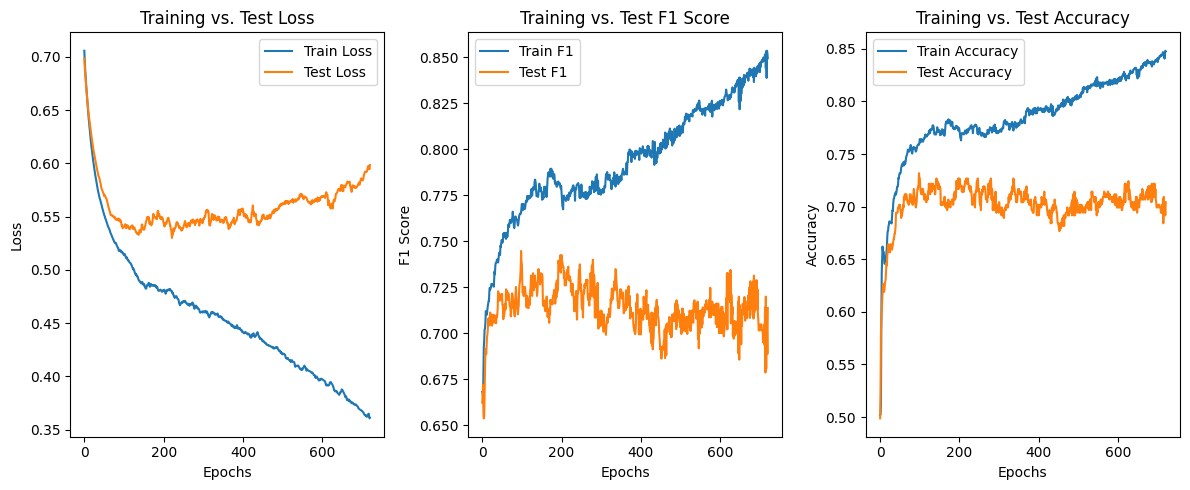

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# plot Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Test Loss")
plt.legend()

# plot f1_score
plt.subplot(1, 3, 2)
plt.plot(train_f1_scores, label="Train F1")
plt.plot(test_f1_scores, label="Test F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training vs. Test F1 Score")
plt.legend()

# accuracies
plt.subplot(1, 3, 3)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## 4. Saving the model

In [30]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "communities_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
f=MODEL_SAVE_PATH)

Saving model to: models\Model_0_CC.pth


## 5. Modifying the Cost function:

the cost function has this formula

$$  L (X) = BinaryCrossEntropy(D {\scriptstyle train}) -  \frac{\lambda}{|D {\scriptstyle negative}|} \cdot \sum_{x \in D {\scriptstyle negative}} C(x)  $$


with C(x) is an approximation of the Cost of Recourse set to be
$$ C(x) = |G{\scriptstyle class 1} - G{\scriptstyle class 2} |$$

G being the logit of that specific class and the approximation being the difference of the logits

Calculating the counterfactuals for the negatively classified instances mutiple times during the training loop can be very costly. That justifies the use of use of an approximation

In [31]:
lamda = 0.05
epochs = 5000
lr = 0.0000001

loaded_model = NeuralNetwork(X.shape[1], 200, 2)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

loss_fn_1 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=lr)

train_losses = []
test_losses = []

for epoch in range(epochs):
    loaded_model.train()
    y_logits = loaded_model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss_1 = loss_fn_1(y_logits, y_train.long())

    y_logits_negative = loaded_model(X_train_negative)
    abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
    loss_2 = torch.mean(abs_differences)

    loss = loss_1 - lamda * loss_2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    loaded_model.eval()
    with torch.inference_mode():
        test_logits = loaded_model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss_1 = loss_fn_1(test_logits, y_test.long())

        y_logits_negative = loaded_model(X_test_negative)
        abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
        test_loss_2 = torch.mean(abs_differences)

        test_loss = test_loss_1 - lamda * test_loss_2

        f1_score_test = f1_score(y_test, test_pred)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    # Refresh classification split
    if epoch % 10 == 0:
        X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
        X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

    # Logging
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch}| Train_Loss: {loss:.5f}| Test loss: {test_loss:.5f}| f1_score_test: {f1_score_test:.5f}")

# best model loading

Epoch: 0| Train_Loss: 0.21614| Test loss: 0.46388| f1_score_test: 0.67857
Epoch: 1000| Train_Loss: 0.21440| Test loss: 0.46245| f1_score_test: 0.67905
Epoch: 2000| Train_Loss: 0.20834| Test loss: 0.45555| f1_score_test: 0.67725
Epoch: 3000| Train_Loss: 0.20377| Test loss: 0.45286| f1_score_test: 0.67905
Epoch: 4000| Train_Loss: 0.20054| Test loss: 0.45084| f1_score_test: 0.67905


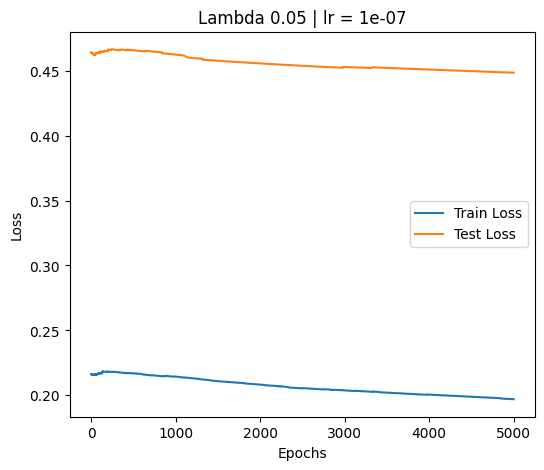

In [32]:
plt.figure(figsize=(6, 5))

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Lambda {lamda} | lr = {lr}")
plt.legend()

## Testing for different Lamdas



Training for lambda = 0.050
Epoch: 0| Train_Loss: 0.21614| Test loss: 0.46388| f1_score_test: 0.67857
Epoch: 10000| Train_Loss: 0.18150| Test loss: 0.44166| f1_score_test: 0.68267
⏹️ Early stopping at epoch 18578 
⏹️ Best Test Loss  0.4343128204345703 
⏹️ Best Epoch  16578 
⏹️ Best_f1_score 0.6808510638297872 


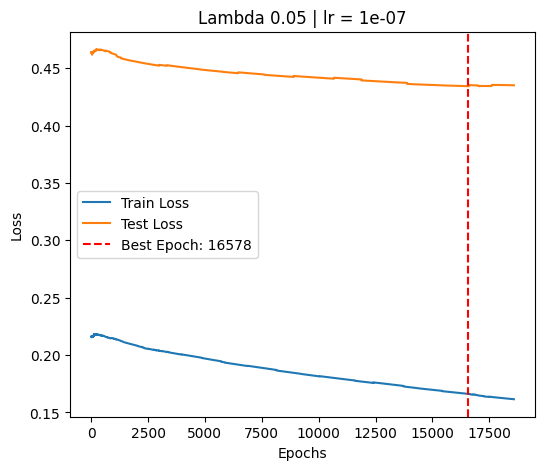


Training for lambda = 0.100
Epoch: 0| Train_Loss: 0.07141| Test loss: 0.33025| f1_score_test: 0.67857
Epoch: 10000| Train_Loss: -0.00138| Test loss: 0.27593| f1_score_test: 0.66292
Epoch: 20000| Train_Loss: -0.06207| Test loss: 0.23883| f1_score_test: 0.65352
Epoch: 30000| Train_Loss: -0.10637| Test loss: 0.22145| f1_score_test: 0.64972
Epoch: 40000| Train_Loss: -0.13893| Test loss: 0.20851| f1_score_test: 0.64972
⏹️ Early stopping at epoch 48934 
⏹️ Best Test Loss  0.19698816537857056 
⏹️ Best Epoch  44934 
⏹️ Best_f1_score 0.6554621848739496 


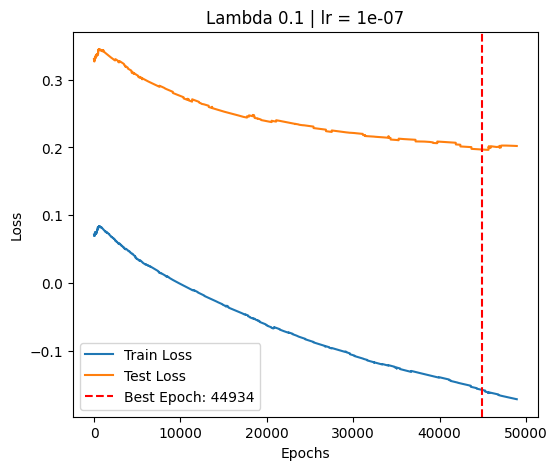


Training for lambda = 0.150
Epoch: 0| Train_Loss: -0.07333| Test loss: 0.19662| f1_score_test: 0.67857
Epoch: 10000| Train_Loss: -0.17605| Test loss: 0.11668| f1_score_test: 0.63284
Epoch: 20000| Train_Loss: -0.28979| Test loss: 0.04466| f1_score_test: 0.62874
Epoch: 30000| Train_Loss: -0.36405| Test loss: -0.01448| f1_score_test: 0.64497
Epoch: 40000| Train_Loss: -0.42310| Test loss: -0.04882| f1_score_test: 0.63529
Epoch: 50000| Train_Loss: -0.47712| Test loss: -0.07725| f1_score_test: 0.64140
Epoch: 60000| Train_Loss: -0.52714| Test loss: -0.07416| f1_score_test: 0.64118
⏹️ Early stopping at epoch 61381 
⏹️ Best Test Loss  -0.0793231725692749 
⏹️ Best Epoch  51381 
⏹️ Best_f1_score 0.641399416909621 


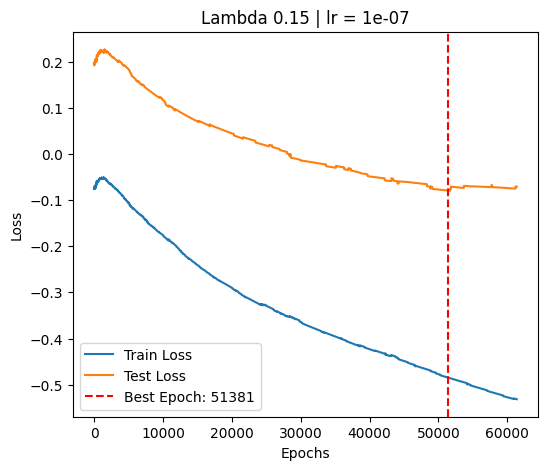


Training for lambda = 0.200
Epoch: 0| Train_Loss: -0.21807| Test loss: 0.06300| f1_score_test: 0.67857
Epoch: 10000| Train_Loss: -0.33562| Test loss: -0.03412| f1_score_test: 0.59236
Epoch: 20000| Train_Loss: -0.49752| Test loss: -0.15864| f1_score_test: 0.59306
Epoch: 30000| Train_Loss: -0.61834| Test loss: -0.24632| f1_score_test: 0.58750
Epoch: 40000| Train_Loss: -0.70626| Test loss: -0.29327| f1_score_test: 0.59748
Epoch: 50000| Train_Loss: -0.79030| Test loss: -0.33888| f1_score_test: 0.60625
Epoch: 60000| Train_Loss: -0.85881| Test loss: -0.37706| f1_score_test: 0.62112
Epoch: 70000| Train_Loss: -0.93645| Test loss: -0.38941| f1_score_test: 0.61682
Epoch: 80000| Train_Loss: -0.99947| Test loss: -0.42861| f1_score_test: 0.61728
Epoch: 90000| Train_Loss: -1.05219| Test loss: -0.41230| f1_score_test: 0.60625
⏹️ Early stopping at epoch 95054 
⏹️ Best Test Loss  -0.42868363857269287 
⏹️ Best Epoch  80054 
⏹️ Best_f1_score 0.6172839506172839 


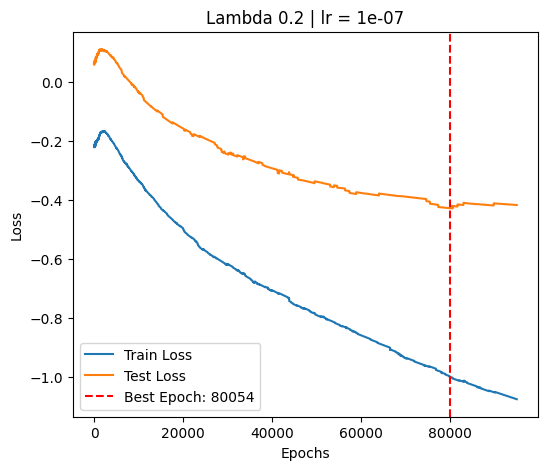


Training for lambda = 0.250
Epoch: 0| Train_Loss: -0.36280| Test loss: -0.07063| f1_score_test: 0.67857
Epoch: 10000| Train_Loss: -0.47788| Test loss: -0.18362| f1_score_test: 0.54237
Epoch: 20000| Train_Loss: -0.71560| Test loss: -0.36596| f1_score_test: 0.54849
Epoch: 30000| Train_Loss: -0.88167| Test loss: -0.48139| f1_score_test: 0.55814
Epoch: 40000| Train_Loss: -0.99567| Test loss: -0.57362| f1_score_test: 0.56106
Epoch: 50000| Train_Loss: -1.10386| Test loss: -0.62706| f1_score_test: 0.56291
Epoch: 60000| Train_Loss: -1.19675| Test loss: -0.66195| f1_score_test: 0.55150
Epoch: 70000| Train_Loss: -1.27664| Test loss: -0.71427| f1_score_test: 0.56766
Epoch: 80000| Train_Loss: -1.36635| Test loss: -0.74697| f1_score_test: 0.56766
Epoch: 90000| Train_Loss: -1.44318| Test loss: -0.77020| f1_score_test: 0.56106
Epoch: 100000| Train_Loss: -1.50240| Test loss: -0.80183| f1_score_test: 0.55921
Epoch: 110000| Train_Loss: -1.55893| Test loss: -0.79829| f1_score_test: 0.54967
Epoch: 120000

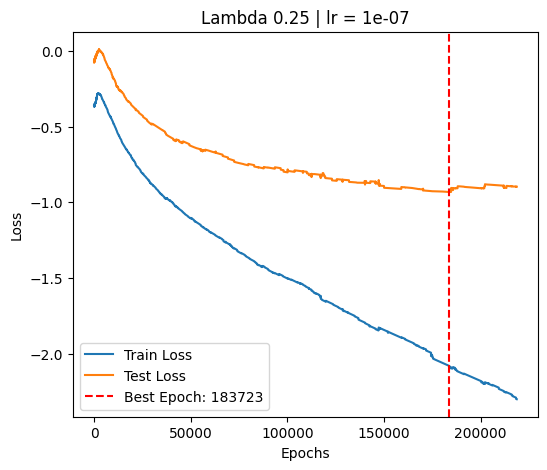


Training for lambda = 0.300
Epoch: 0| Train_Loss: -0.50754| Test loss: -0.20426| f1_score_test: 0.67857
Epoch: 10000| Train_Loss: -0.61741| Test loss: -0.29500| f1_score_test: 0.44776
Epoch: 20000| Train_Loss: -0.92332| Test loss: -0.55855| f1_score_test: 0.48746
Epoch: 30000| Train_Loss: -1.14627| Test loss: -0.71806| f1_score_test: 0.49470
Epoch: 40000| Train_Loss: -1.31507| Test loss: -0.86945| f1_score_test: 0.51903
Epoch: 50000| Train_Loss: -1.43772| Test loss: -0.94846| f1_score_test: 0.51211
Epoch: 60000| Train_Loss: -1.56607| Test loss: -1.02618| f1_score_test: 0.51034
Epoch: 70000| Train_Loss: -1.66668| Test loss: -1.06429| f1_score_test: 0.50000
Epoch: 80000| Train_Loss: -1.78924| Test loss: -1.13706| f1_score_test: 0.51034
Epoch: 90000| Train_Loss: -1.88291| Test loss: -1.18146| f1_score_test: 0.51724
Epoch: 100000| Train_Loss: -1.97015| Test loss: -1.24381| f1_score_test: 0.52740
Epoch: 110000| Train_Loss: -2.05101| Test loss: -1.30456| f1_score_test: 0.53061
Epoch: 120000

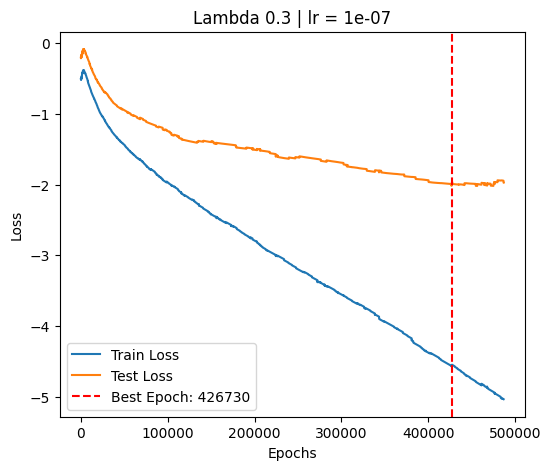

In [33]:
lambdas = [0.05,0.1,0.15,0.2,0.25,0.3]
lr = 0.0000001
patiences = [2000, 4000, 10000, 15000, 35000, 60000]
starting_epoch =3000
delta = 0.001

model1= NeuralNetwork(X.shape[1], 200, 2)
model2= NeuralNetwork(X.shape[1], 200, 2)
model3= NeuralNetwork(X.shape[1], 200, 2)
model4= NeuralNetwork(X.shape[1], 200, 2)
model5= NeuralNetwork(X.shape[1], 200, 2)
model6= NeuralNetwork(X.shape[1], 200, 2)
models = [model1, model2, model3, model4, model5, model6]
best_f1_scores = []

for lamda, best_model, patience in zip(lambdas, models, patiences):
    epochs = 600000

    delta = 0.001
    best_test_loss = float('inf')
    counter = 0


    print(f"\nTraining for lambda = {lamda:.3f}")

    loaded_model = NeuralNetwork(X.shape[1], 200, 2)
    loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


    X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
    X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

    loss_fn_1 = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(loaded_model.parameters(), lr= lr)

    train_losses = []
    test_losses = []
    for epoch in range(epochs):

        # Refresh classification split
        if epoch % 10 == 0:
            X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
            X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

        loaded_model.train()
        y_logits = loaded_model(X_train)
        y_pred = torch.argmax(y_logits, dim=1)
        loss_1 = loss_fn_1(y_logits, y_train.long())

        y_logits_negative = loaded_model(X_train_negative)
        abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
        loss_2 = torch.mean(abs_differences)

        loss = loss_1 - lamda * loss_2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluation
        loaded_model.eval()
        with torch.inference_mode():
            test_logits = loaded_model(X_test)
            test_pred = torch.argmax(test_logits, dim=1)
            test_loss_1 = loss_fn_1(test_logits, y_test.long())

            y_logits_negative = loaded_model(X_test_negative)
            abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
            test_loss_2 = torch.mean(abs_differences)
            test_loss = test_loss_1 - lamda * test_loss_2

            f1_score_test = f1_score(y_test, test_pred)


        train_losses.append(loss.item())
        test_losses.append(test_loss.item())


        # Logging
        if epoch % 10000 == 0:
            print(f"Epoch: {epoch}| Train_Loss: {loss:.5f}| Test loss: {test_loss:.5f}| f1_score_test: {f1_score_test:.5f}")

        if epoch > starting_epoch:
            # early stopping
            if test_loss.item() < best_test_loss - delta:
                best_test_loss = test_loss.item()
                best_epoch = epoch
                best_f1_score = f1_score_test
                counter = 0
                best_model_state = loaded_model.state_dict()
            else:
                counter += 1
                if counter >= patience:
                    print(f"⏹️ Early stopping at epoch {epoch} ")
                    print(f"⏹️ Best Test Loss  {best_test_loss} ")
                    print(f"⏹️ Best Epoch  {best_epoch} ")
                    print(f"⏹️ Best_f1_score {best_f1_score} ")
                    best_f1_scores.append(best_f1_score)

                    plt.figure(figsize=(6, 5))

                    plt.plot(train_losses, label="Train Loss")
                    plt.plot(test_losses, label="Test Loss")
                    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f"Best Epoch: {best_epoch}")
                    plt.xlabel("Epochs")
                    plt.ylabel("Loss")
                    plt.title(f"Lambda {lamda} | lr = {lr}")
                    plt.legend()

                    plt.show()

                    break

    best_model.load_state_dict(best_model_state)


In [38]:
for (model, lamda) in zip(models, lambdas):
    model_save_path = f"models/communities_model_lambda_{lamda:.2f}.pth"
    torch.save(model.state_dict(), model_save_path)

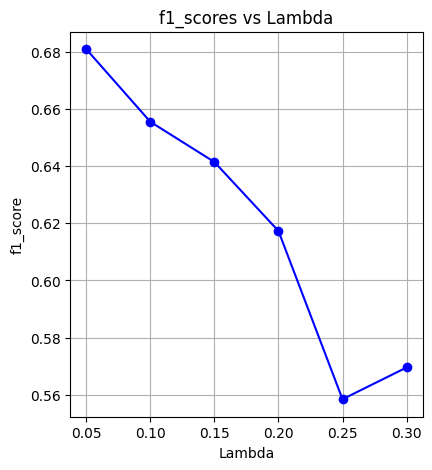

In [39]:
plt.figure(figsize=(10, 5))
# f1_score
plt.subplot(1, 2, 1)
plt.plot(lambdas, best_f1_scores, marker='o', color='blue')
plt.title("f1_scores vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("f1_score")
plt.grid(True)
